<a href="https://colab.research.google.com/github/AndreiPopa1906/NeuralNetworks/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision libraries



*   torchvision
*   torchvision.datasets
*   torchvision.models
*   torchvision.transforms
*   torch.utils.data.Dataset
*   torch.utils.data.DataLoader







In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# 1. Getting a dataset

In [ ]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training set?
    download=True, # do we want to download yes/no?
    transform=ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=False , # do we want the training set?
    download=True, # do we want to download yes/no?
    transform=ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/targets?
)



In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [ ]:
class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

(-0.5, 27.5, 27.5, -0.5)

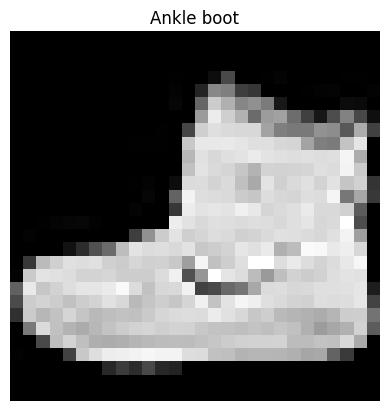

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_name[label])
plt.axis("off")

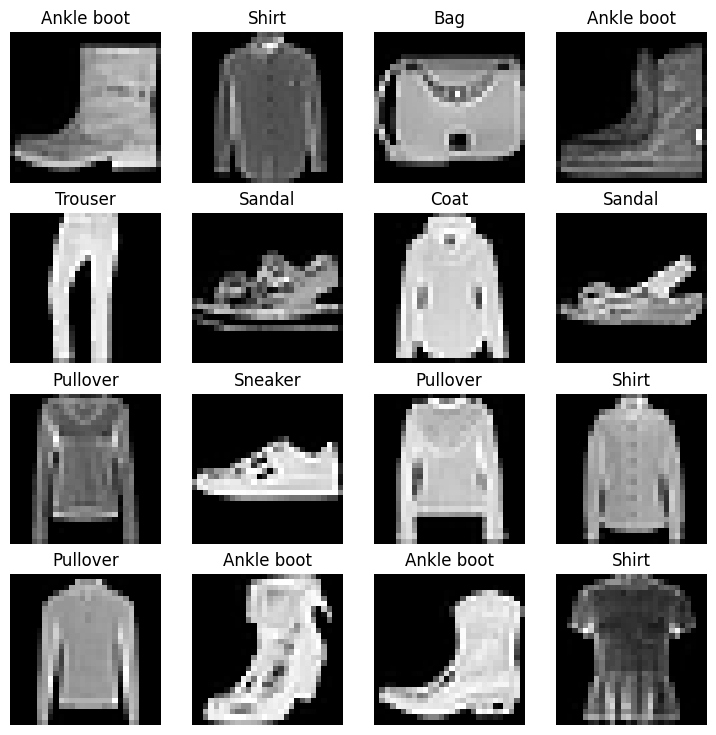

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, 1+rows*cols):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(class_name[label])
  plt.axis("off")

# 2. Preparing DataLoader

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False
)

In [ ]:
print(f"Dataloader: {train_dataloader}\nLength: {len(train_dataloader)}\nType: {type(train_dataloader)}")
print(f"Dataloader: {test_dataloader}\nLength: {len(test_dataloader)}\nType: {type(test_dataloader)}")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7ac031c44d90>
Length: 1875
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7ac031c47a60>
Length: 313
Type: <class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

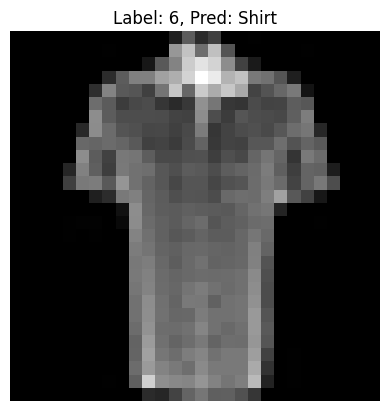

In [ ]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Label: {label}, Pred: {class_name[label]}")
plt.axis("off")

# 3. Building a baseline model

In [ ]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)
print(f"Shape before flattening: {x.shape}\nShape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)




model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_name)).to("cpu")
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x).shape

torch.Size([1, 10])

In [ ]:
import requests
from pathlib import Path

if(Path("helper_functions.py").is_file()):
    print("File already exists")
else:
    print("Downloading file")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        print("File downloaded")

File already exists


In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
from tqdm.auto import tqdm

epoch = 3

start_train_time_on_cpu = timer()

for epoch in tqdm(range(epoch)):
    print(f"Epoch: {epoch}\n-------")

    train_loss = 0
    train_acc = 0

    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looking at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f}")

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()

    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

    train_time_end_on_cpu = timer()
    print_train_time(start=train_time_end_on_cpu, end=timer(),
                     device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looking at 0/60000 samples.
Looking at 12800/60000 samples.
Looking at 25600/60000 samples.
Looking at 38400/60000 samples.
Looking at 51200/60000 samples.
Train loss: 0.91325
Test loss: 0.63561, Test accuracy: 78.15495
Train time on cpu: 0.000 seconds
Epoch: 1
-------
Looking at 0/60000 samples.
Looking at 12800/60000 samples.
Looking at 25600/60000 samples.
Looking at 38400/60000 samples.
Looking at 51200/60000 samples.
Train loss: 0.56485
Test loss: 0.54889, Test accuracy: 81.29992
Train time on cpu: 0.000 seconds
Epoch: 2
-------
Looking at 0/60000 samples.
Looking at 12800/60000 samples.
Looking at 25600/60000 samples.
Looking at 38400/60000 samples.
Looking at 51200/60000 samples.
Train loss: 0.50799
Test loss: 0.51917, Test accuracy: 81.79912
Train time on cpu: 0.000 seconds


# 4. Making predictions

In [ ]:
torch.manual_seed(42)
def eval_model(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}


model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                              accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.519170880317688,
 'model_acc': 81.7991214057508}

#5. Building a better model using non-linearity

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs in a single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)


model_1 = FashionMNISTModelV1(input_shape=784, hidden_units=10, output_shape=len(class_name)).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

# Training


*   training - train_step()
*   testing - test_step()



In [ ]:
def train_step(model: nn.Module,
              data_loader: DataLoader,
              loss_fn: nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}, Train accuracy: {train_acc:.2f}%\n")

In [ ]:
def test_step(model:nn.Module,
              data_loader: DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%\n")


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(model=model_1,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn)
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

train_time_end = timer()
print_train_time(start=train_time_start, end=train_time_end, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.98248, Train accuracy: 65.06%

Test loss: 0.76060, Test accuracy: 72.80%

Epoch: 1
-------
Train loss: 0.70366, Train accuracy: 74.48%

Test loss: 0.71731, Test accuracy: 73.67%

Epoch: 2
-------
Train loss: 0.67375, Train accuracy: 75.31%

Test loss: 0.69170, Test accuracy: 74.81%

Train time on cpu: 42.375 seconds


42.37530243299989

# Concolutional Neural Network

In [ ]:
class FasihionMNISTModelV2(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = FasihionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_name)).to(device)
model_2

FasihionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
torch.manual_seed(42)

images = torch.randn(size=(32, 1, 64, 64)).to(device)
test_image = images[0]
print(f"Image shape: {test_image.shape}")
print(f"Image batch shape: {image.shape}")


Image shape: torch.Size([1, 64, 64])
Image batch shape: torch.Size([1, 28, 28])


In [ ]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3, 3), stride=1, padding=0)
conv_output = conv_layer(test_image.repeat(1,3,1,1))
conv_output

tensor([[[[-0.9424, -1.1567, -0.9239,  ..., -0.4870,  0.1111, -0.3643],
          [-0.1264,  1.2597,  0.5318,  ...,  0.1628,  0.0823,  0.0857],
          [-0.1820, -0.8547, -0.0418,  ...,  0.2093, -0.0512, -0.0883],
          ...,
          [-0.0076, -0.0755, -0.2041,  ...,  0.5116, -0.8521, -0.4792],
          [ 0.3775,  0.4520,  0.1766,  ..., -1.0749,  0.3327,  0.8099],
          [ 0.1458,  0.3880,  0.1478,  ...,  0.3011, -0.0388,  0.2293]],

         [[ 0.6602, -0.4147, -0.0703,  ...,  0.2355, -0.5261,  0.6059],
          [-0.6043, -0.4837,  0.7138,  ..., -0.2706,  0.2151,  0.3179],
          [-0.0318,  0.0324, -0.8772,  ..., -0.1346,  0.2874, -0.1971],
          ...,
          [ 0.4844,  0.0119, -0.5715,  ..., -0.0383,  0.4616, -0.4240],
          [ 0.3017,  0.2213, -0.1000,  ..., -0.1496, -0.9923,  0.0219],
          [-0.0684,  0.0141,  0.4461,  ..., -0.6956, -0.3121, -0.0247]],

         [[ 0.4730,  0.0246, -0.0153,  ...,  0.6081,  1.0986,  0.1938],
          [ 1.0682,  0.4595, -

In [ ]:
rand_image_tensor = torch.randn(size=(1,28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
model_2(rand_image_tensor.unsqueeze(dim=0).to(device))

tensor([[ 0.0382, -0.0892,  0.0799, -0.0317,  0.0130,  0.0409,  0.0114, -0.0052,
         -0.0011, -0.0307]], grad_fn=<AddmmBackward0>)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, end=train_time_end_model_2, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.59518, Train accuracy: 78.38%

Test loss: 0.39500, Test accuracy: 85.99%

Epoch: 1
-------
Train loss: 0.36536, Train accuracy: 86.90%

Test loss: 0.35244, Test accuracy: 86.91%

Epoch: 2
-------
Train loss: 0.32588, Train accuracy: 88.13%

Test loss: 0.32719, Test accuracy: 88.07%

Train time on cpu: 247.944 seconds


In [ ]:
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

In [ ]:
model_2_results

{'model_name': 'FasihionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc': 88.06908945686901}

In [ ]:
import pandas as pd
compare_results = pd.DataFrame(data=[model_0_results,  model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.519171,81.799121
1,FasihionMNISTModelV2,0.327190,88.069089


In [ ]:
def make_predictions(model: nn.Module,
                    data: list,
                    device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            sample = sample.to(device)

            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)


test_samples[0].shape


torch.Size([1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

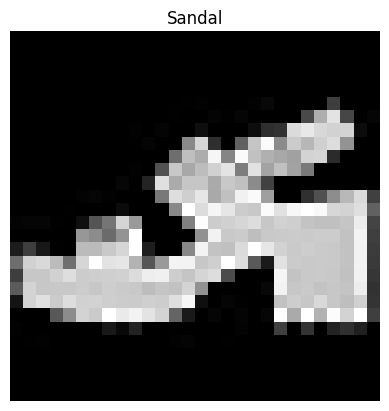

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_name[test_labels[0]])
plt.axis("off")

In [ ]:
pred_probs = make_predictions(model=model_2, data=test_samples)
pred_probs

tensor([[1.4021e-06, 1.7343e-07, 4.4511e-07, 1.2103e-05, 5.4026e-07, 9.9938e-01,
         3.7154e-06, 2.1650e-04, 1.4199e-04, 2.4416e-04],
        [1.0080e-01, 5.6287e-01, 7.4506e-04, 1.1212e-01, 6.3881e-02, 3.0674e-04,
         1.5560e-01, 1.6463e-03, 1.0169e-03, 1.0133e-03],
        [3.8239e-05, 1.2338e-06, 3.2391e-05, 6.0269e-05, 1.5860e-05, 1.9636e-03,
         7.6249e-06, 7.8097e-01, 1.9226e-03, 2.1498e-01],
        [7.8742e-04, 1.3270e-04, 1.6981e-01, 1.3967e-03, 8.2655e-01, 3.1661e-06,
         1.0841e-03, 1.2137e-05, 2.1172e-04, 1.7749e-05],
        [8.6987e-02, 5.9945e-05, 2.1540e-04, 8.9260e-01, 5.0072e-04, 4.4561e-07,
         1.9359e-02, 2.6450e-05, 2.3960e-04, 7.3933e-06],
        [8.5208e-01, 5.0843e-05, 1.6163e-03, 9.2852e-03, 7.7607e-03, 9.1815e-07,
         1.2845e-01, 2.6501e-06, 7.5505e-04, 6.0906e-07],
        [5.2980e-04, 3.9070e-05, 3.2348e-02, 2.5166e-05, 9.5285e-01, 5.1364e-06,
         1.3197e-02, 1.5579e-06, 9.7135e-04, 3.7291e-05],
        [6.0402e-06, 6.1119

In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [ ]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

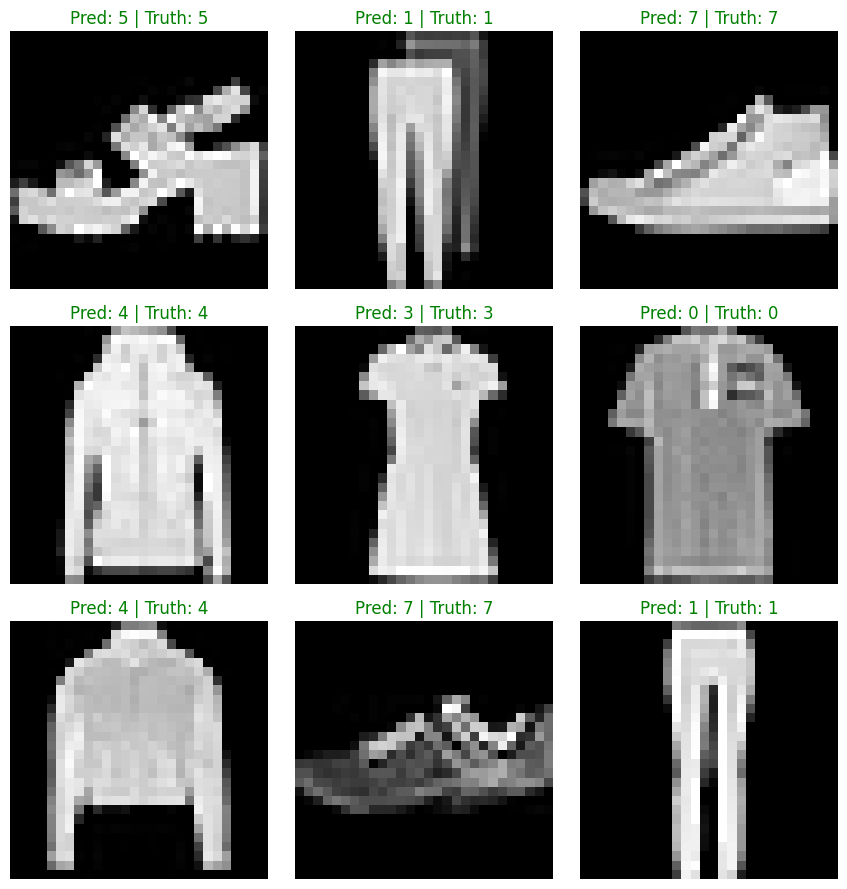

In [ ]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)

    plt.imshow(sample.squeeze(), cmap="gray")

    color = "green" if pred_classes[i] == test_labels[i] else "red"
    plt.title(f"Pred: {pred_classes[i]} | Truth: {test_labels[i]}", color=color)
    plt.axis("off")
    plt.tight_layout()

In [ ]:
# Make a confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=test_labels, y_pred=pred_classes)
cm

array([[1, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 2]])

In [ ]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc = "Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]


Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 4, 8, 0, 2, 9, 7, 5,
        1, 2, 6, 3, 9, 3, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 9, 6, 7, 2, 1, 4, 6, 4, 4, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 3, 3, 3, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 3, 8, 5, 9, 5, 0, 3, 2,
        0, 2, 5, 3, 6, 7, 1, 8]), tensor([6, 1, 6, 2, 3, 6, 7, 6, 7, 8, 5, 9, 9, 4, 2, 5, 7, 6, 5, 2, 8, 6, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4]), tensor([1, 5, 4, 1, 9, 1, 8, 6, 6, 1, 2, 5, 1, 6, 0, 0, 1, 6, 1, 3, 2, 2, 2, 4,
        1, 4, 5, 6, 4, 7, 9, 3]), tensor([8, 2, 3, 8, 0, 9, 4, 8, 4, 2, 6, 5, 6, 1, 2, 1, 3, 6, 8, 1, 0, 9, 3, 6,
        7, 9, 9, 4, 4, 7, 1, 2]), tensor([3, 6, 3, 6, 8, 3, 6, 1, 1, 6, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 6, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 6, 0]), tensor([7, 7, 6, 3, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 3, 2, 5, 4, 9, 2, 2, 8, 6, 4,
        6, 2, 9, 7, 3, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 6, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 2,
       

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [ ]:
try:
    import torchmetrics, mlextend
    print("torchmetrics and mlxtend already installed")
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend

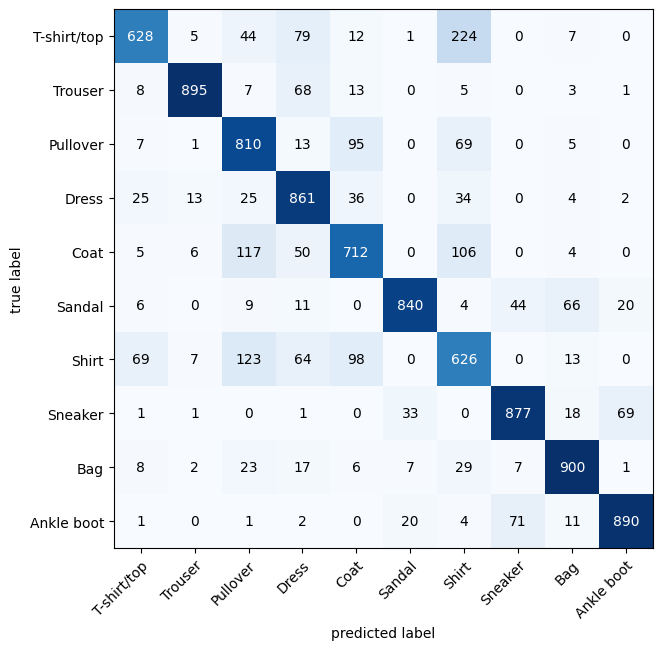

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_name))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names=class_name,
                                figsize=(10,7))


In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_model_fashion_MNIST_CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
loaded_model_2 = FasihionMNISTModelV2(input_shape=1,
                                      hidden_units=10,
                                      output_shape=len(class_name))
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2

FasihionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)